# Import module

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import lime
import lime.lime_text
import string
import pickle
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/tadasuttaket/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# Import data

In [81]:
df1 = pd.read_csv('./data/email_classification.csv')

In [82]:
df2 = pd.read_csv('./data/spam_ham_dataset.csv')

In [83]:
df1.head(5)

,email,label
0,Upgrade to our premium plan for exclusive acce...,ham
1,Happy holidays from our team! Wishing you joy ...,ham
2,We're hiring! Check out our career opportuniti...,ham
3,Your Amazon account has been locked. Click her...,spam
4,Your opinion matters! Take our survey and help...,ham


In [84]:
# Swap the column
df1 = df1[['label', 'email']]

In [85]:
df1.columns = ['Category','Message']

In [86]:
df2.head(5)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [87]:
df2 = df2.drop(df2.columns[[0, 3]], axis=1)

In [88]:
df2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [89]:
df2.columns = ['Category','Message']

In [90]:
df = pd.concat([df1, df2], ignore_index=True)
df

,Category,Message
0,ham,Upgrade to our premium plan for exclusive acce...
1,ham,Happy holidays from our team! Wishing you joy ...
2,ham,We're hiring! Check out our career opportuniti...
3,spam,Your Amazon account has been locked. Click her...
4,ham,Your opinion matters! Take our survey and help...
...,...,...
5345,ham,Subject: put the 10 on the ft\r\nthe transport...
5346,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...
5347,ham,Subject: calpine daily gas nomination\r\n>\r\n...
5348,ham,Subject: industrial worksheets for august 2000...


# Preprocessing

In [91]:
# Define the preprocess function
def preprocess_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Convert to lowercase
    text = text.lower()
    # Tokenize words => cut the word
    words = nltk.word_tokenize(text)
    # POS tagging
    pos_tags = nltk.pos_tag(words)

    # Filter out less meaningful words based on their POS tags
    # Keep only nouns, verbs, adjectives, and adverbs
    meaningful_pos = {'NN', 'NNS', 
                      'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 
                      'JJ', 'JJR', 'JJS',
                      'RB', 'RBR', 'RBS'}
    filtered_words = [word for word, pos in pos_tags if pos in meaningful_pos]

    return ' '.join(filtered_words)

# Define PreprocessTextTransformer class
class PreprocessTextTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(preprocess_text)
        
df['Message'] = df['Message'].apply(preprocess_text)
df

,Category,Message
0,ham,upgrade premium plan exclusive access premium ...
1,ham,happy holidays team wishing joy prosperity season
2,ham,were hiring check career opportunities join dy...
3,spam,amazon account has been locked click here veri...
4,ham,opinion matters take survey help enhance exper...
...,...,...
5345,ham,subject put ft transport volumes decreased be ...
5346,ham,subject following noms hpl t take extra mmcf d...
5347,ham,subject calpine daily gas nomination julie i m...
5348,ham,subject industrial worksheets august activity ...


In [92]:
df.shape

(5350, 2)

In [93]:
# Find unique Category
df['Category'].value_counts()

ham     3772
spam    1578
Name: Category, dtype: int64

In [94]:
# Remove rows with invalid categories
valid_categories = ['ham', 'spam']
df = df[df['Category'].isin(valid_categories)]
df.shape

(5350, 2)

In [95]:
# Encode the 'Category' column: 0 for ham, 1 for spam
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [96]:
df

,Category,Message
0,0,upgrade premium plan exclusive access premium ...
1,0,happy holidays team wishing joy prosperity season
2,0,were hiring check career opportunities join dy...
3,1,amazon account has been locked click here veri...
4,0,opinion matters take survey help enhance exper...
...,...,...
5345,0,subject put ft transport volumes decreased be ...
5346,0,subject following noms hpl t take extra mmcf d...
5347,0,subject calpine daily gas nomination julie i m...
5348,0,subject industrial worksheets august activity ...


In [97]:
# Drop duplicates row
df.drop_duplicates(inplace=True)
df

,Category,Message
0,0,upgrade premium plan exclusive access premium ...
1,0,happy holidays team wishing joy prosperity season
2,0,were hiring check career opportunities join dy...
3,1,amazon account has been locked click here veri...
4,0,opinion matters take survey help enhance exper...
...,...,...
5343,1,subject slutty milf wants meet take ilaa liqaa
5345,0,subject put ft transport volumes decreased be ...
5346,0,subject following noms hpl t take extra mmcf d...
5348,0,subject industrial worksheets august activity ...


In [98]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

# EDA

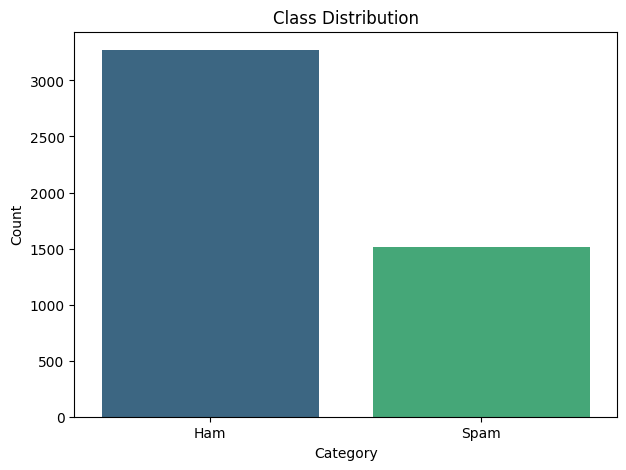

In [20]:
# Plot class distribution
plt.figure(figsize=(7,5))
sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

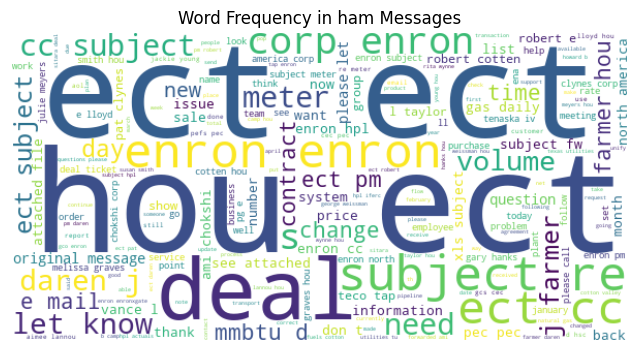

In [21]:
hamtext = ' '.join(df[df['Category'] == 0]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(hamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in ham Messages')
plt.show()

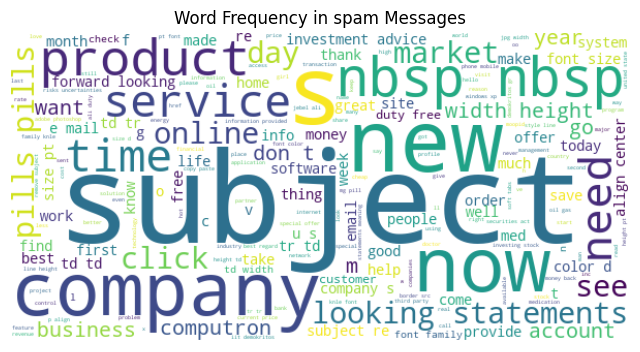

In [22]:
spamtext = ' '.join(df[df['Category'] == 1]['Message'])

# Generate a word cloud
wordcloud = WordCloud(width=600, height=300, background_color='white').generate(spamtext)

# Display the word cloud
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency in spam Messages')
plt.show()

# Split train and test set

In [23]:
X = df['Message']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Feature engineering

In [24]:
# tfidf_vectorizer = TfidfVectorizer(max_features=5000) initializes the vectorizer with a maximum of 5,000 features. 
# This means it will only consider the top 5,000 words (based on their TF-IDF scores) as features, 
# which helps in reducing dimensionality and computational cost.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test = tfidf_vectorizer.transform(X_test).toarray()

# Model Selection

<Figure size 800x600 with 0 Axes>

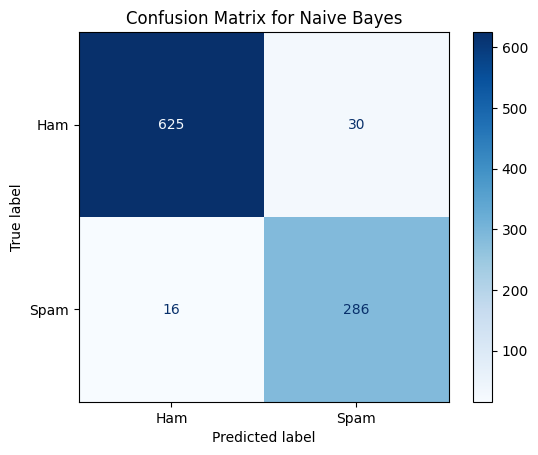

Naive Bayes Accuracy: 0.95
Naive Bayes Time Taken: 0.10 seconds
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       655
           1       0.91      0.95      0.93       302

    accuracy                           0.95       957
   macro avg       0.94      0.95      0.95       957
weighted avg       0.95      0.95      0.95       957



<Figure size 800x600 with 0 Axes>

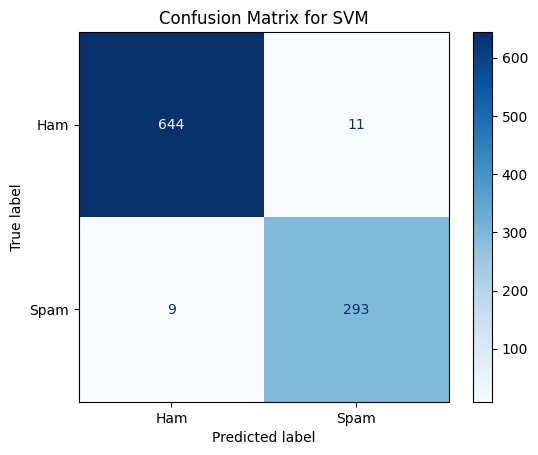

SVM Accuracy: 0.98
SVM Time Taken: 23.33 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       655
           1       0.96      0.97      0.97       302

    accuracy                           0.98       957
   macro avg       0.98      0.98      0.98       957
weighted avg       0.98      0.98      0.98       957



<Figure size 800x600 with 0 Axes>

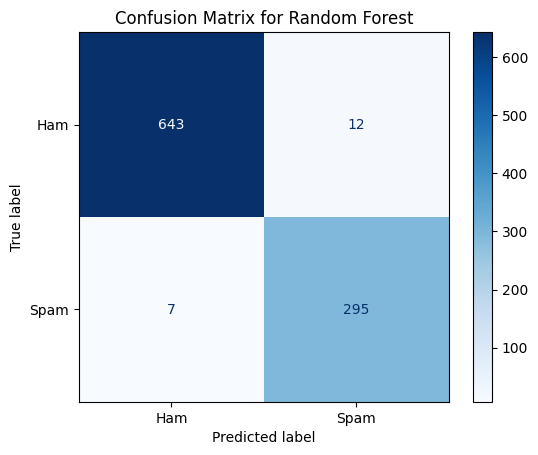

Random Forest Accuracy: 0.98
Random Forest Time Taken: 1.55 seconds
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       655
           1       0.96      0.98      0.97       302

    accuracy                           0.98       957
   macro avg       0.98      0.98      0.98       957
weighted avg       0.98      0.98      0.98       957



In [40]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results_accuracy = {}
results_precision = {}
results_f1_score = {}
results_recall = {}
results_time = {}

# Cross-validation loop with time tracking
for model_name, model in models.items():
    start_time = time.time()  # Start time tracking
    
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Capture the end time and calculate the elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Store the results
    results_accuracy[model_name] = accuracy
    results_precision[model_name] = precision
    results_f1_score[model_name] = f1
    results_recall[model_name] = recall
    results_time[model_name] = elapsed_time  # Store elapsed time
    
    # Print results
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Time Taken: {elapsed_time:.2f} seconds")
    print(classification_report(y_test, y_pred))

<Figure size 800x600 with 0 Axes>

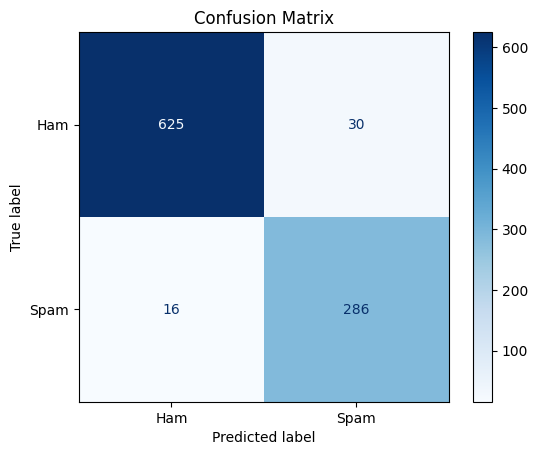

Naive Bayes Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       655
           1       0.91      0.95      0.93       302

    accuracy                           0.95       957
   macro avg       0.94      0.95      0.95       957
weighted avg       0.95      0.95      0.95       957



<Figure size 800x600 with 0 Axes>

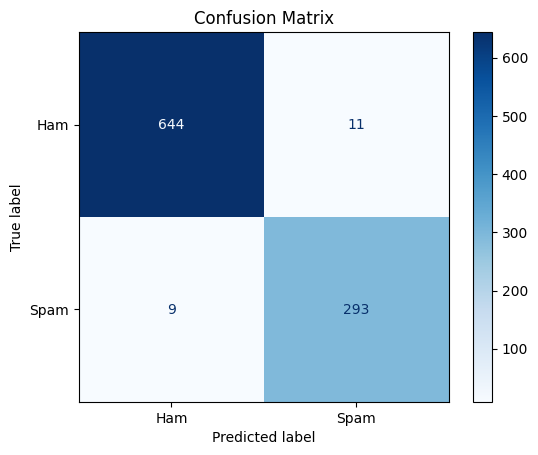

SVM Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       655
           1       0.96      0.97      0.97       302

    accuracy                           0.98       957
   macro avg       0.98      0.98      0.98       957
weighted avg       0.98      0.98      0.98       957



<Figure size 800x600 with 0 Axes>

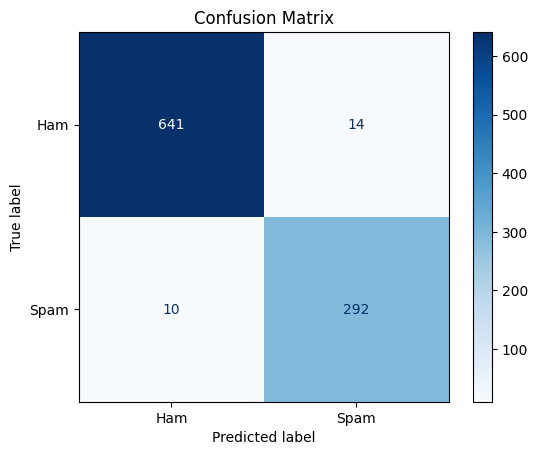

Random Forest Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       655
           1       0.95      0.97      0.96       302

    accuracy                           0.97       957
   macro avg       0.97      0.97      0.97       957
weighted avg       0.98      0.97      0.97       957



In [25]:
# Closs validate way
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

results_accuracy = {}
results_precision = {}
results_f1_score = {}
results_recall = {}

# Closs validate
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

    results_accuracy[model_name] = accuracy
    results_precision[model_name] = precision
    results_f1_score[model_name] = f1
    results_recall[model_name] = recall
    
    # # Model pickle
    # model_filename = f"{model_name}_model.pkl"
    # with open(model_filename, 'wb') as file:
    #     pickle.dump(model, file)
    # print(f"{model_name} saved as {model_filename}\n\n")


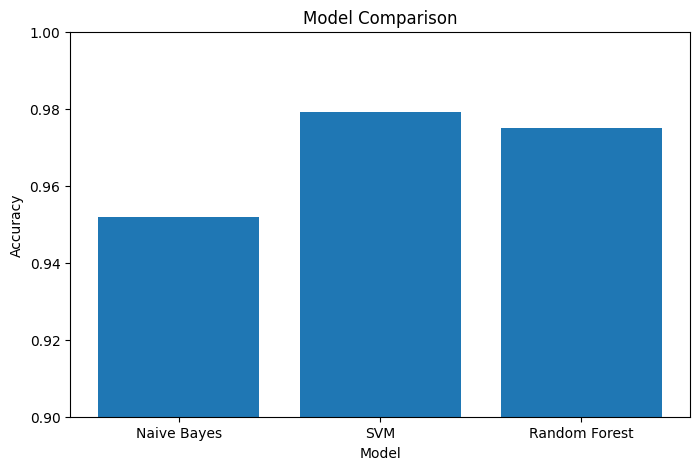

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(results_accuracy.keys(), results_accuracy.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)
plt.show()

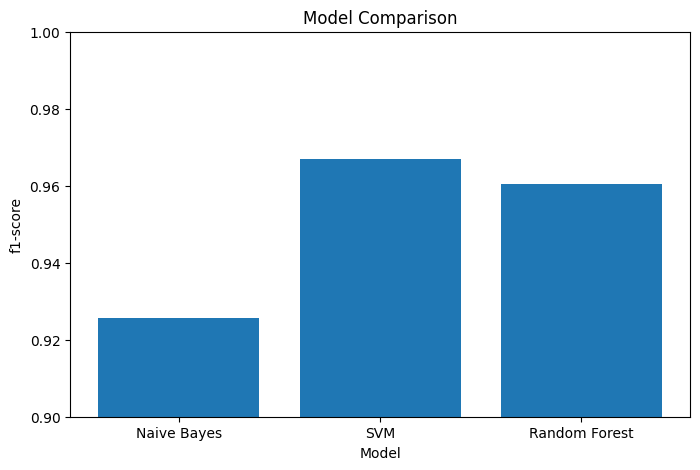

In [27]:
plt.figure(figsize=(8, 5))
plt.bar(results_f1_score.keys(), results_f1_score.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('f1-score')
plt.ylim(0.9, 1.0)
plt.show()

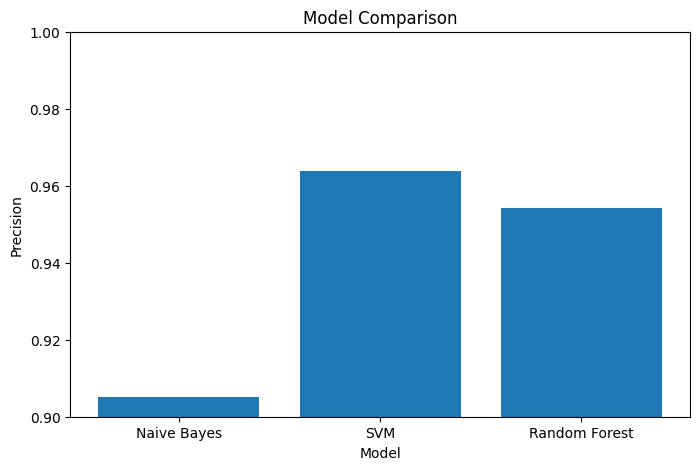

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(results_precision.keys(), results_precision.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.ylim(0.9, 1.0)
plt.show()

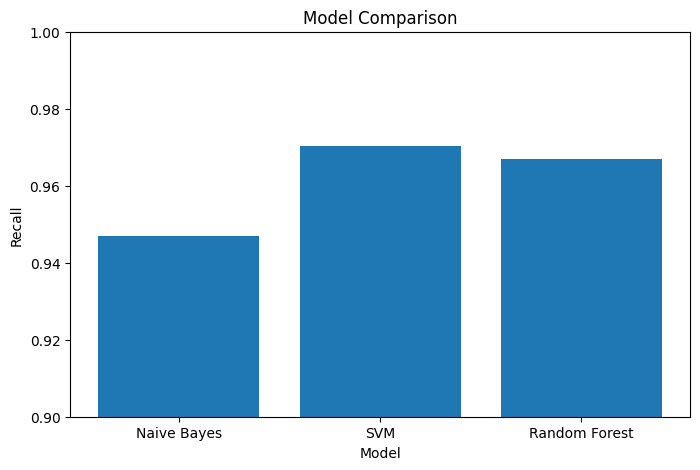

In [29]:
plt.figure(figsize=(8, 5))
plt.bar(results_recall.keys(), results_recall.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.ylim(0.9, 1.0)
plt.show()

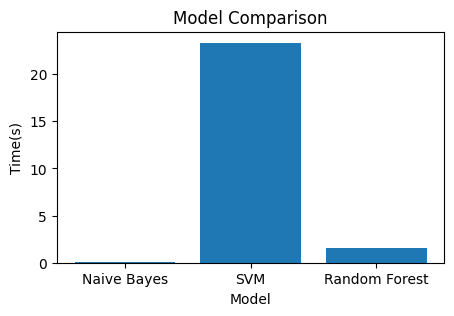

In [44]:
plt.figure(figsize=(5, 3))
plt.bar(results_time.keys(), results_time.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Time(s)')
plt.show()

# GridsearchCV with pipeline

In [30]:
df_for_pipeline = pd.concat([df1, df2], ignore_index=True)

In [31]:
# df_for_pipeline['Message'] = df_for_pipeline['Message'].apply(preprocess_text)

In [32]:
# Encode the 'Category' column: 0 for ham, 1 for spam
df_for_pipeline['Category'] = df_for_pipeline['Category'].map({'ham': 0, 'spam': 1})

In [33]:
# Drop duplicates row
df.drop_duplicates(inplace=True)

In [34]:
Xp = df_for_pipeline['Message']
yp = df_for_pipeline['Category']

In [35]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2, random_state=50)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


<Figure size 800x600 with 0 Axes>

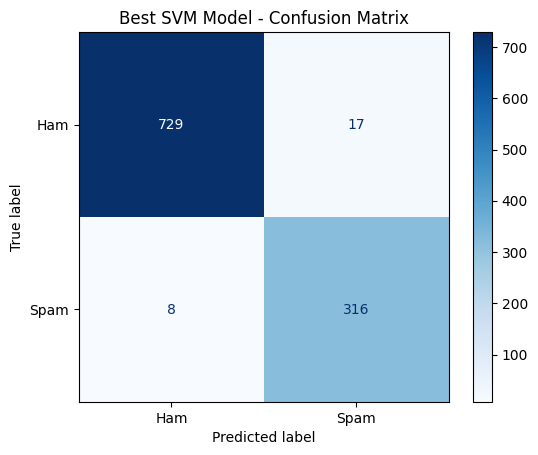

Best SVM Model Params: {'classifier__C': 1, 'classifier__gamma': 0.01, 'classifier__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       746
           1       0.95      0.98      0.96       324

    accuracy                           0.98      1070
   macro avg       0.97      0.98      0.97      1070
weighted avg       0.98      0.98      0.98      1070



In [36]:
# Define the parameter grid for SVM
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': [0.01, 0.1],
    'classifier__kernel': ['linear', 'rbf']
}

# Define pipeline with an SVM classifier
pipeline_svm = Pipeline([
    ('preprocess', PreprocessTextTransformer()),
    ('vectorizer', TfidfVectorizer(max_features=5000)),
    ('classifier', SVC(probability=True))
])

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline_svm, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(Xp_train, yp_train)

# Get the best model and evaluate
best_model = grid_search.best_estimator_
yp_pred = best_model.predict(Xp_test)

# Evaluate
cm = confusion_matrix(yp_test, yp_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Best SVM Model - Confusion Matrix")
plt.show()

print(f"Best SVM Model Params: {grid_search.best_params_}")
print(classification_report(yp_test, yp_pred))

# Save the best model

In [37]:
# Save the grid search best model
with open('best_svm_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# LIME

In [139]:
X2 = df['Message']
y2 = df['Category']

# Split into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=50)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X2_train_tfidf = vectorizer.fit_transform(X2_train)
X2_test_tfidf = vectorizer.transform(X2_test)

# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

# Train models
for model_name, model in models.items():
    model.fit(X2_train_tfidf, y2_train)

# Function to predict probabilities for LIME (required for explanation)
def predict_proba(model, texts):
    tfidf_texts = vectorizer.transform(texts)  # Transform the input texts to TF-IDF vectors
    return model.predict_proba(tfidf_texts)    # Return predicted probabilities

# Now, let's use LIME to explain the predictions of a model for a test instance

# Choose a test instance to explain
email_to_explain = X2_test.iloc[900]  # Take the first email from the test set for example

# Choose the model you'd like to explain. Let's use Naive Bayes for this example
chosen_model = models['SVM']

# Initialize LIME explainer for text
explainer = lime.lime_text.LimeTextExplainer(class_names=['ham', 'spam'])

# Explain the model's prediction for the selected email
explanation = explainer.explain_instance(email_to_explain, 
                                         lambda texts: predict_proba(chosen_model, texts), 
                                         num_features=10)

# Visualize the explanation (this will open a visualization in a notebook environment)
explanation.show_in_notebook()

# If you want to print out the explanation, you can also do:
print(explanation.as_list())



[('texas', -0.03807594441695444), ('enron', -0.027117112266026734), ('thanks', -0.020670257456994565), ('comparison', 0.019519817684233092), ('attached', -0.018441671770057236), ('questions', -0.016120093136883302), ('june', -0.01601357941079349), ('elizabeth', 0.015871035077494017), ('daren', -0.015487682917331227), ('contact', -0.011906361415039831)]


In [134]:
X2_test.iloc[900]

'subject monthly budget vs actual comparison reports texas daren attached are texas monthly budget vs actual comparison reports june july august please contact questions thanks elizabeth elizabeth webb elizabeth webb enron com'

In [135]:
y2_test.iloc[900]

0

# Feature words in the model

In [131]:
import numpy as np
import pandas as pd

# Assuming you have trained an SVM model (e.g., chosen_model) and the vectorizer is `vectorizer`
# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get the coefficients from the SVM model (ensure it's in a dense format)
coef = chosen_model.coef_.toarray().flatten()  # Convert sparse matrix to dense array and flatten

# Combine the words with their coefficients
svm_features = list(zip(feature_names, coef))

# Separate the words into Spam (positive coefficients) and Ham (negative coefficients)
spam_features = [x for x in svm_features if x[1] > 0]  # Words with positive coefficients (Spam)
ham_features = [x for x in svm_features if x[1] < 0]   # Words with negative coefficients (Ham)

# Sort by the absolute value of the coefficient to get the most influential words
spam_features_sorted = sorted(spam_features, key=lambda x: abs(x[1]), reverse=True)
ham_features_sorted = sorted(ham_features, key=lambda x: abs(x[1]), reverse=True)

# Convert to DataFrame for better readability
spam_df = pd.DataFrame(spam_features_sorted, columns=['Word', 'Coefficient'])
ham_df = pd.DataFrame(ham_features_sorted, columns=['Word', 'Coefficient'])

# Show the top 20 most influential words for each class
print("Top words for Spam:")
print(spam_df.head(10))

print("\nTop words for Ham:")
print(ham_df.head(10))


Top words for Spam:
            Word  Coefficient
0        subject     2.177686
1           http     1.517160
2         remove     1.485649
3           here     1.471995
4          click     1.405233
5          money     1.343666
6          hello     1.303709
7  international     1.268931
8       security     1.265799
9         mobile     1.258981

Top words for Ham:
       Word  Coefficient
0     enron    -2.945993
1    thanks    -2.207333
2       doc    -1.765851
3     meter    -1.573253
4  attached    -1.553981
5     texas    -1.524473
6     daren    -1.429743
7  pictures    -1.409576
8      deal    -1.346471
9     yahoo    -1.346079
